In [2]:
### replicate results of EVmutation with the PABP_YEAST dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy

In [3]:
NAME = 'PABP_YEAST'

In [4]:
### cut down training size to 10000 samples
if NAME != "PABP_YEAST":
    number = NAME.split('_')[2]
    fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
    with open(f"PABP_YEAST/data/{NAME}.a2m", "w+") as out_file:
        cnt = 0
        seq = []
        for fasta in fasta_sequences:
            seq.append(fasta)
            cnt += 1
            if cnt >= 10000:
                break
        SeqIO.write(seq, out_file, "fasta")

In [7]:
### training code for model
!plmc/bin/plmc -o PABP_YEAST/model/{NAME}.model_params -c PABP_YEAST/model/{NAME}.txt -f PABP_YEAST -le 16.2 -lh 0.01 -m 200 -t 0.2 -g PABP_YEAST/data/{NAME}.a2m

Found focus PABP_YEAST as sequence 1
151496 valid sequences out of 152041 
82 sites out of 96
Region starts at 115
Effective number of samples (to 1 decimal place): 18615.5	(80% identical neighborhood = 1.000 samples)
iter	time	cond	fx	-loglk	||h||	||e||
1	1.5	668.45	2803680.4	2803612.2	72.1	1.0
2	2.2	1317.47	2530380.0	2526756.6	72.1	14.8
3	2.8	1387.57	2507890.2	2498735.3	72.1	23.7
4	3.5	658.49	2409702.7	2401575.0	72.1	22.3
5	4.2	637.79	2383657.9	2376482.3	72.0	21.0
6	4.9	407.33	2361117.0	2353416.7	72.0	21.7
7	5.6	478.18	2297750.2	2288016.6	72.0	24.4
8	6.3	549.61	2213983.4	2198656.6	71.9	30.7
9	7.7	707.63	2182939.6	2163878.2	71.9	34.3
10	8.3	477.00	2147279.0	2123692.2	71.9	38.1
11	9.0	424.40	2114991.4	2087527.3	71.9	41.1
12	9.7	646.70	2086447.8	2052652.6	71.9	45.6
13	10.4	331.04	2063943.8	2030772.3	71.9	45.2
14	11.2	275.17	2043127.9	2009362.5	71.9	45.6
15	11.9	294.50	2018508.1	1981338.2	71.9	47.9
16	12.6	455.42	1995078.0	1951677.0	71.8	51.7
17	13.3	301.11	1976134.6	1926882.9	71.8	55.1


In [5]:
def EVmutation_results(NAME="PABP_YEAST"):
    # load parameters from file to create a pairwise model
    c = CouplingsModel(f"PABP_YEAST/model/{NAME}.model_params")
    # read the experimental mutational scanning dataset for PABP by Melamed et al., RNA, 2013
    data = pd.read_csv(
        "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
    )

    # predict mutations using our model
    data_pred = tools.predict_mutation_table(
        c, data, "effect_prediction_epistatic"
    )

    # can also add predictions by the corresponding independent model
    c0 = c.to_independent_model()

    data_pred = tools.predict_mutation_table(
        c0, data_pred, "effect_prediction_independent"
    )
    print(data_pred.head())

    singles = tools.single_mutant_matrix(
        c, output_column="effect_prediction_epistatic"
    )

    print(singles.head())
    pred = data_pred['effect_prediction_epistatic']
    pred_ind = data_pred['effect_prediction_independent']
    label = data_pred['linear']
    print('evmutation spearman: ', scipy.stats.spearmanr(pred, label))
    print('independent control spearman: ', scipy.stats.spearmanr(pred_ind, label))

In [6]:
EVmutation_results("PABP_YEAST")
print('=======')
EVmutation_results("PABP_YEAST_10000")

  mutant    linear       log  effect_prediction_epistatic  \
0  G126A  0.711743 -0.490571                    -2.601740   
1  G126C  0.449027 -1.155127                    -5.648695   
2  G126E  0.588928 -0.763836                    -6.598581   
3  G126D  0.229853 -2.121218                    -7.250636   
4  G126N  0.679435 -0.557593                    -5.800188   

   effect_prediction_independent  
0                       0.406487  
1                      -0.027602  
2                      -1.827570  
3                      -1.180076  
4                       0.387440  
  mutant  pos wt subs  frequency  effect_prediction_epistatic
0  K123A  123  K    A   0.077201                     0.807069
1  K123C  123  K    C   0.001461                    -3.332515
2  K123D  123  K    D   0.118235                    -0.304472
3  K123E  123  K    E   0.110503                    -1.060114
4  K123F  123  K    F   0.007791                    -3.003125
evmutation spearman:  SpearmanrResult(correlation=0

Running SVM on this set of data

In [7]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
# Protein amino acid alphabet + gap character "-"
alphabet = '-ACDEFGHIKLMNPQRSTVWY'
# map amino acids to index
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
# map index to amino acids
i_to_a = {i:aa for i, aa in enumerate(alphabet)}

In [8]:
def encode(seqs, alphabet=ALPHABET_PROTEIN):
    '''
    Go from letters to numbers
    '''
    aa_to_i = OrderedDict((aa, i) for i, aa in enumerate( alphabet ))
    X = np.asarray([[aa_to_i[x] for x in seq] 
                    for seq in seqs])
    return X, aa_to_i

def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True

def one_hot_encode(s):
    ''' one hot encode sequence'''
    return np.eye(21)[s].flatten()
def process_msa_sequence(msa_sequences):
    ''' takes in list of sequences and one-hot encodes the sequences'''
    # get wild-type sequence
    wt_seq = msa_sequences[0]
    # keep all the columns
    columns_to_keep = [i for i in range(len(wt_seq))]
    # upper case all letters
    msa_sequences = [[s[i].upper() for i in columns_to_keep] for s in msa_sequences]
    # replace "." with "-"
    msa_sequences = [[aa.replace(".", "-") for aa in s] for s in msa_sequences]
    msa_sequences = np.asarray(msa_sequences)
    # keep sequences that pass check_sequence
    msa_sequences = [s for s in msa_sequences if check_sequence(s)]
    msa_sequences = np.asarray(msa_sequences)

    seqs_enc, aa_to_i = encode(msa_sequences)
    i_to_a = {i:aa for i, aa in enumerate(ALPHABET_PROTEIN)}
    oh_enc_seq = []
    for s in seqs_enc:
        oh_enc_seq.append(one_hot_encode(s))
    oh_enc_seq = np.asarray(oh_enc_seq)
    return oh_enc_seq

In [9]:
# read in fasta files
yeast_seq = [str(x.seq) for x in SeqIO.parse('EVmutation/example/PABP_YEAST.a2m', 'fasta')]
wildtype = yeast_seq[0]
yeast_seq = process_msa_sequence(yeast_seq)

In [10]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel='poly', degree=2, nu=0.3)
train = yeast_seq[:50000]
clf.fit(train)

OneClassSVM(degree=2, kernel='poly', nu=0.3)

In [11]:
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
mutant, label = data['mutant'].to_numpy(), data['linear'].to_numpy()
mutant_data = []
for m in mutant:
    original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
    assert wildtype[loc] == original_aa
    mutant_data.append(wildtype[:loc]+mutant_aa+wildtype[loc+1:])
mutant_data = np.asarray(mutant_data)
mutant_data = process_msa_sequence(mutant_data)

In [12]:
### about labelling in the data: for linear, > 1 --> generally neutral mutation, probability of neutral mutation decreases as
### enrichment score gets lower

In [15]:
train_pred = clf.decision_function(train[:10000])
msa_pred = clf.decision_function(yeast_seq[50000:60000])
mut_pred_pos = clf.decision_function(mutant_data[np.where(label>=1)])
mut_pred_neg = clf.decision_function(mutant_data[np.where(label<1)])


In [1]:
plt.hist(train_pred, alpha=0.6)
plt.hist(msa_pred, alpha=0.6)
plt.hist(mut_pred_pos, alpha=0.8)
plt.hist(mut_pred_neg, alpha=0.8)

NameError: name 'plt' is not defined

G

(array([ 63.,  72.,  54.,  95., 133., 129., 305., 112.,  25.,   7.]),
 array([-386.41248625, -376.37461419, -366.33674212, -356.29887006,
        -346.26099799, -336.22312592, -326.18525386, -316.14738179,
        -306.10950973, -296.07163766, -286.0337656 ]),
 <BarContainer object of 10 artists>)

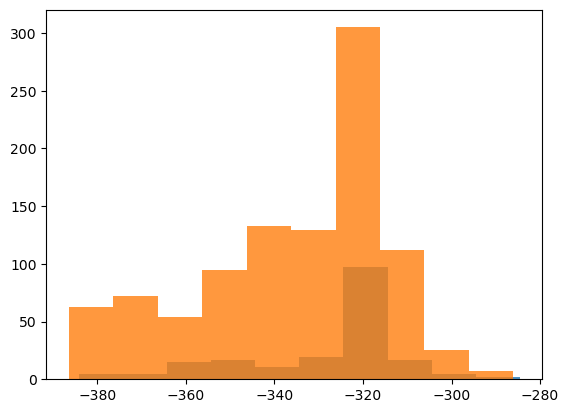

In [17]:
plt.hist(mut_pred_pos, alpha=0.8)
plt.hist(mut_pred_neg, alpha=0.8)